In [1]:
import numpy as np
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import pickle
import sys
import heapq
import seaborn as sns
from pylab import rcParams
import collections
from keras_tqdm import TQDMNotebookCallback
from keras.callbacks import LambdaCallback, ModelCheckpoint
from livelossplot import PlotLossesKeras


%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 5

C:\Users\dex\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

In [3]:
path = 'my messages.txt'
text = open(path, encoding="utf8").read().lower()
print('Corpus length:', len(text))

Corpus length: 2775400


In [4]:
text = text.replace("\U0001f928", " ").replace("\U0001f929", " ").replace("\U0001f92b", " ").replace("\U0001f92c", " ").replace("\U0001f92f", " ")
to_delete_chars = ['\U0001f9d0', '\U0001f9d4', '\ue608', '\ue60a', '\uf032','\uf0b7', '\ufeff', '\u2009',
                  '\u200b','\u200d', '\t', '\uf033', '\\', '»', '/', '█','ӱ',';','z', 'w', 'm','h','u','i', 
                  'g','f','y','v','k', '♀', '🏃','s','r','l']

In [5]:
to_delete_chars = ['\U0001f9d0', '\U0001f9d4', '\ue608', '\ue60a', '\uf032', '\uf0b7', '\ufeff', '\u2009', '\u200b', '\u200d', '\t', '\uf033', '\\', '»', '/', '█', 'ӱ', ';', 'z', 'w', 'm', 'h', 'u', 'i', 'g', 'f', 'y', 'v', 'k', '♀', '🏃', 's', 'r', 'l', '\\', '`', '#', '<', '>', '{', '}', '№', '💪', '[', "'", ']', '́', '−', '|', '█', '@', '~', '$', '^', 'ң', 'җ', '👍', '😭', '🤷', '😢', '✊', '😉', '💰', '😅', '👨', '💻', '🤔', '🥔', '🍅', '🥒', '∙', '🙄', '“', '”', '„', '²', '₽', '…', '🤤', '😂', '😁', '°', '😊', '€', '£', '’', '🤝', '🤦', '♂', '😪', '😰', '😎', '😯', '🎁', '😔', '😳', '😴', '😄', '😌', '😮', '😱', '😃', '\u200b', '🙈', '👺', '😈', '👿', '👽', '😐', '🐓', '💩', '😲', '💆', '🔥', 'κ', 'ώ', 'ν', 'ο', 'ς', 'ὀ', 'δ', 'ύ', '🤑', '😑', '❤', '🐻', '🎩', '↵', '↑', '😆', 'ç', '😜', '┻', '┳', '•', '⊂', 'ﾉ', '👻', '😒', '🔨', '🔫', '\uf032', '\uf033', '\uf031', '🍖', '🎉', '💴', '💵', '🏦', '💳', '\ue60a', '\ue608', '🍃', '🍀', '🌿', '😇', '😋', '®', '·', '\ufeff', '😕', '😦', 'ә', '©', 'ө', 'ґ', 'ї', 'ѕ', '±', '🍷', '🍭', '🏆', '💥', '⚽', '😬', '🙆', '👌', '☺', '😘', '😍', '🚌', '🔐', '🔑', '🥑', '✅', '🥚', '🍳', '🧀', '\U0001f9d0', '☠', '\U0001f9d4', '🏻', '参', '加', '这', '次', '运', '动', '会', '，', '你', '的', '目', '标', '是', '什', '么', '？', '（', '海', '南', '电', '视', '台', '口', '）', '🐈', '🤗', 'ö', '‘', '焼', 'き', '鳥', 'ı', '̇', 'ş', '🌂', '🤓', '🛫', '✈', '🎪', '🌍', '✨', '🌮', '😞', '🌱', '😵', '🏡', '👏', '¯', 'ツ', '🎭', '🙂', '🎄', '🍾', '🎆', '🎊', '🐤', '🐥', '👈', '🐝', '🌽', '🙉', '🙊', '👊', '😨', 'ä', '🎈', '🥞', '🚙', '⚕', '🙃', '✋', '😩', '👆', '😓', '👹', '×', '™', '🍆', '⚠', '☕', '🗳', '💭', '😖', '🦆', '🍺', '🤙', 'ó', 'è', 'é', '\uf0b7', '🎹', '🌙', '🌹', '🍂', '☀', '🐼', '🙏', '🌷', '🌸', '🎥', '🎿', '🍕', '😏', 'ӱ', '\u2009', '∗', 'ɛ', '\t', ' ', '&', 'q', 'j', '«', '  ', '&', 'q', 'j', '«', '   ', '&', 'q', 'j', '«', '    ', '&', 'q', 'j', '«', '     ', '&', 'q', 'j', '«', '  ', '&', 'q', 'j', '«', '  ', '&', 'q', 'j', '«', '         ', '&', 'q', 'j', '«']

In [6]:
dic = collections.Counter(text)
for val in dic:
    if dic[val] < 346: 
        to_delete_chars.append(val)
to_delete_chars.append('         ')
to_delete_chars.append('&')
to_delete_chars.append('q')
to_delete_chars.append('j')
to_delete_chars.append('«')


In [7]:
for del_char in to_delete_chars:
    text = text.replace(del_char, ' ')
text = text.replace('\'', '"')

In [8]:
# create mapping of unique chars to integers
chars = sorted(list(set(text)))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print(f'Unique chars: {len(chars)}')

Unique chars: 72


In [9]:
#some random chars
chars[0:10]

['\n', ' ', '!', '"', '%', '(', ')', '*', '+', ',']

In [15]:
SEQUENCE_LENGTH = 40
step = 2
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])
print(f'num training examples: {len(sentences)}')

X = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

num training examples: 1353262


In [21]:
def buildmodel():
    model = Sequential()
    model.add(LSTM(128*2, input_shape = (SEQUENCE_LENGTH, len(chars))))
    #model.add(Dropout(0.15))
    #model.add(LSTM(128))
    #model.add(Dropout(0.10))
    #model.add(Dense(len(chars)*5, activation = 'softmax'))
    model.add(Dense(len(chars), activation = 'softmax'))
  
    model.compile(loss = 'categorical_crossentropy', optimizer = RMSprop(lr=0.01), metrics=['accuracy'])
    return model
filepath = "weights.hdf5"
checkpoint = ModelCheckpoint( filepath,
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

In [22]:
model = buildmodel()

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 256)               336896    
_________________________________________________________________
dense_3 (Dense)              (None, 72)                18504     
Total params: 355,400
Trainable params: 355,400
Non-trainable params: 0
_________________________________________________________________


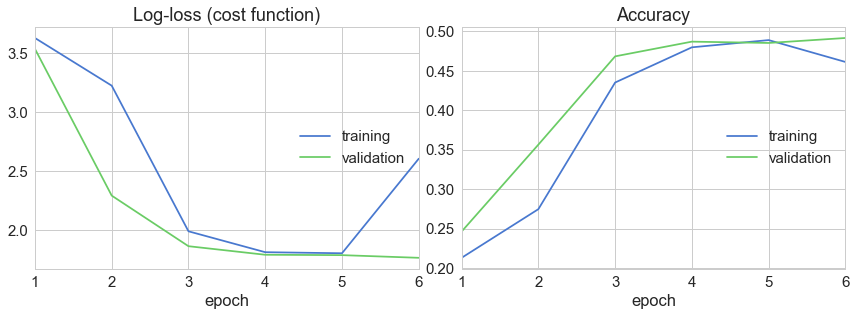

In [24]:
history = model.fit(X, y, validation_split=0.20, batch_size=512, epochs=6, shuffle=True,verbose=2, callbacks=[TQDMNotebookCallback(),checkpoint, PlotLossesKeras()]).history

In [25]:
#ETA: 3:31 - loss: 2.0615 - acc: 0.4683

In [26]:
model.save('keras_model_doubleLSTMvk.h5')
pickle.dump(history, open("history.p", "wb"))

In [27]:
model = load_model('5033weights.hdf5')
#history = pickle.load(open("history.p", "rb"))

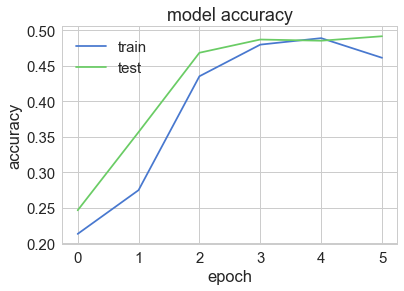

In [28]:
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

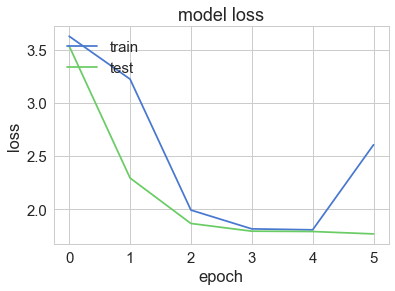

In [29]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left');

In [30]:
def prepare_input(text):
    x = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [31]:
prepare_input("Я поеду на работу, но заеду ".lower())

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [32]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [33]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]
        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [34]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [41]:
quotes = [
    "Я поеду на работу, но нужно еще зайти к hr",
    "Департамент развития аналитических решений и системных сервисов ",
    "Сложная очень задача получается но это ничего не отменяет",
    "Надо изучать машинку и идти к пониманию да ",
    "ещё печенки немного поговорить на улице и в салоне"
]

In [42]:
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

я поеду на работу, но нужно еще зайти к 
['концу ', 'том ', 'успеха ', 'нему ', 'собеседование ']

департамент развития аналитических решен
['ие ', 'тами ', 'а ', ' стоит ', 'ных ']

сложная очень задача получается но это н
['е ', 'а ', 'орм ', 'ичего ', 'ужно ']

надо изучать машинку и идти к пониманию 
['в ', 'с ', 'по ', 'и ', 'на ']

ещё печенки немного поговорить на улице 
['\n ', 'по ', 'на ', 'с ', 'в ']

